# Transportation Models

In [1]:
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

installing pyomo . pyomo installed
installing and testing solvers ...
.. glpk installed
.. gecode
.. ipopt
.. bonmin
.. couenne
.. gurobi_direct installed
.. cbc installed
installation and testing complete


## Distributing Gasoline to Franchise Operators

YaYa Gas-n-Grub is franchiser and operator for a network of regional convenience stores selling gasoline and convenience items. Each store is individually owned by a YaYa Gas-n-Grub franchisee who pays a fixed fee to the franchisor for services.

Gasoline is delivered to each store by truck from a regional distribution terminal. The stores sell an average of about 4,000 gallons daily for an average profit of about &dollar;100 for the franchise owners, but sales vary widely based on location. Each delivery truck carrys 8,000 gallons. Under the current business agreement, the gasoline is delivered at a fixed charge of &dollar;700 per delivery, or 11.43 cents per gallon. The franchise owners are eager to reduce delivery costs to boost profits, but the current distributor claims a lower price would be unsustainable.

YaYa Gas-n-Grub decides to accept proposals from other distribution terminals, "A" and "B", to supply the franchise operators. They each provide delivery pricing based on location. Since they already have existing customers, "A" and "B" can only provide a limited amount of gasoline to new customers, 100,000 and 150,000 gallons respectively. The only difference between the new suppliers and the incumbant is the delivery charge, the cost of gasoline is determined on the pipeline market is the same among the distributors. 

The following chart shows the pricing of gasoline delivery in cents/gallon.

| Store Owner | Demand |  Termina A | Terminal B | Incumbant |
| :-------- | ------------: | ---------: | -------: | --------: |
| Alice | 30,000 | 8.3 | 10.2 | 8.75 |
| Badri  | 40,000 | 8.1 | 12.0 | 8.75 |
| Cara  | 50,000 | 8.3 | - | 8.75 |
| Dan   | 80,000 | 9.3 | 8.0 |  8.75 |
| Emma  | 30,000 | 10.1 | 10.0 | 8.75 |
| Fujita | 45,000 | 9.8 | 10.0 | 8.75 |
| Grace | 80,000 | -  | 8.0 | 8.75 |
| Helen | 18,000 | 7.5 | 10.0 | 8.75 |
| **TOTALS**| 313,000 | 100,000 | 150,000 | 500, 000 | 370,000 |

### Task

As operator of YaYa Gas-n-Grub, allocate the delivery of gasoline to minimize overall cost to the frachise owners.

### Analysis

A majority of the franchise owners must agree with the new contract in order to proceed. Will the franchise owers agree?  Who might object to the new arrangment, and why?


,Terminal A,Terminal B,Incumbant
Alice,8.3,10.2,8.75
Badri,8.1,12.0,8.75
Cara,8.3,100.0,8.75
Dan,9.3,8.0,8.75
Emma,10.1,10.0,8.75
Fujita,9.8,10.0,8.75
Grace,100.0,8.0,8.75
Helen,7.5,10.0,8.75


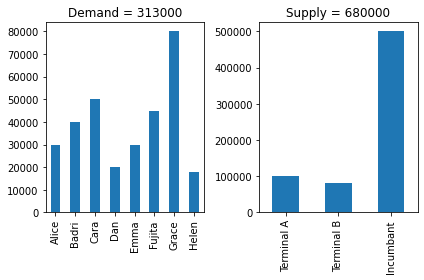

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

rates = pd.DataFrame({
    "Alice": {"Terminal A": 8.3, "Terminal B": 10.2, "Incumbant": 8.75},
    "Badri": {"Terminal A": 8.1, "Terminal B": 12.0, "Incumbant": 8.75},
    "Cara": {"Terminal A": 8.3, "Terminal B": 100, "Incumbant": 8.75},
    "Dan": {"Terminal A": 9.3, "Terminal B": 8.0, "Incumbant": 8.75},
    "Emma": {"Terminal A": 10.1, "Terminal B": 10.0, "Incumbant": 8.75},
    "Fujita": {"Terminal A": 9.8, "Terminal B": 10.0, "Incumbant": 8.75},
    "Grace": {"Terminal A": 100, "Terminal B": 8.0, "Incumbant": 8.75},
    "Helen": {"Terminal A": 7.5, "Terminal B": 10.0, "Incumbant": 8.75}}).T

display(rates)

demand = pd.Series({
    "Alice": 30000,
    "Badri": 40000,
    "Cara": 50000,
    "Dan": 20000,
    "Emma": 30000,
    "Fujita": 45000,
    "Grace": 80000,
    "Helen": 18000})

supply = pd.Series({
    "Terminal A": 100000,
    "Terminal B": 80000,
    "Incumbant": 500000})

fix, ax = plt.subplots(1, 2)
demand.plot(kind="bar", ax=ax[0], title=f"Demand = {demand.sum()}")
supply.plot(kind="bar", ax=ax[1], title=f"Supply = {supply.sum()}")
plt.tight_layout()

In [3]:
import pyomo.environ as pyo

def transport(supply, demand, rates):
    m = pyo.ConcreteModel()

    m.SOURCES = pyo.Set(initialize=rates.columns)
    m.DESTINATIONS = pyo.Set(initialize=rates.index)

    m.x = pyo.Var(m.DESTINATIONS, m.SOURCES, domain=pyo.NonNegativeReals)

    @m.Param(m.DESTINATIONS, m.SOURCES)
    def Rates(m, dst, src):
        return rates.loc[dst, src]

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        return sum(m.Rates[dst, src]*m.x[dst, src] for dst, src in m.DESTINATIONS * m.SOURCES)
    
    @m.Expression(m.DESTINATIONS)
    def cost_to(m, dst):
        return sum(m.Rates[dst, src]*m.x[dst, src] for src in m.SOURCES)

    @m.Expression(m.DESTINATIONS)
    def shipped_to(m, dst):
        return sum(m.x[dst, src] for src in m.SOURCES)

    @m.Expression(m.SOURCES)
    def shipped_from(m, src):
        return sum(m.x[dst, src] for dst in m.DESTINATIONS)

    @m.Constraint(m.SOURCES)
    def supply_constraint(m, src):
        return m.shipped_from[src] <= supply[src]

    @m.Constraint(m.DESTINATIONS)
    def demand_constraint(m, dst):
        return m.shipped_to[dst] >= demand[dst]

    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    pyo.SolverFactory('cbc').solve(m)

    return m

m = transport(supply, demand, rates/100)

results = pd.DataFrame({dst: {src: m.x[dst, src]() for src in m.SOURCES} for dst in m.DESTINATIONS}).T
results["current costs"] = 700*demand/8000
results["contract costs"] = pd.Series({dst: m.cost_to[dst]() for dst in m.DESTINATIONS})
results["savings"] = results["current costs"].round(1) - results["contract costs"].round(1)
results["marginal cost"]  = pd.Series({dst: m.dual[m.demand_constraint[dst]] for dst in m.DESTINATIONS})

print(f"Old Delivery Costs = $ {sum(demand)*700/8000}")
print(f"New Delivery Costs = $ {m.cost()}")
display(results)


Old Delivery Costs = $ 27387.5
New Delivery Costs = $ 26113.5


,Terminal A,Terminal B,Incumbant,current costs,contract costs,savings,marginal cost
Alice,30000.0,0.0,0.0,2625.0,2490.0,135.0,0.0875
Badri,40000.0,0.0,0.0,3500.0,3240.0,260.0,0.0855
Cara,12000.0,0.0,38000.0,4375.0,4321.0,54.0,0.0875
Dan,0.0,20000.0,0.0,1750.0,1600.0,150.0,0.0875
Emma,0.0,0.0,30000.0,2625.0,2625.0,0.0,0.0875
Fujita,0.0,0.0,45000.0,3937.5,3937.5,0.0,0.0875
Grace,0.0,60000.0,20000.0,7000.0,6550.0,450.0,0.0875
Helen,18000.0,0.0,0.0,1575.0,1350.0,225.0,0.0795


## Pyomo solution reports

In [4]:
m.SOURCES.display()

SOURCES : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    3 : {'Terminal A', 'Terminal B', 'Incumbant'}


In [5]:
m.DESTINATIONS.display()

DESTINATIONS : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    8 : {'Alice', 'Badri', 'Cara', 'Dan', 'Emma', 'Fujita', 'Grace', 'Helen'}


In [6]:
m.Rates.display()

Rates : Size=24, Index=Rates_index, Domain=Any, Default=None, Mutable=False
    Key                      : Value
      ('Alice', 'Incumbant') :              0.0875
     ('Alice', 'Terminal A') :               0.083
     ('Alice', 'Terminal B') :               0.102
      ('Badri', 'Incumbant') :              0.0875
     ('Badri', 'Terminal A') :               0.081
     ('Badri', 'Terminal B') :                0.12
       ('Cara', 'Incumbant') :              0.0875
      ('Cara', 'Terminal A') :               0.083
      ('Cara', 'Terminal B') :                 1.0
        ('Dan', 'Incumbant') :              0.0875
       ('Dan', 'Terminal A') : 0.09300000000000001
       ('Dan', 'Terminal B') :                0.08
       ('Emma', 'Incumbant') :              0.0875
      ('Emma', 'Terminal A') : 0.10099999999999999
      ('Emma', 'Terminal B') :                 0.1
     ('Fujita', 'Incumbant') :              0.0875
    ('Fujita', 'Terminal A') :               0.098
    ('Fujita', 'Term

In [7]:
m.shipped_to.display()

shipped_to : Size=8
    Key    : Value
     Alice : 30000.0
     Badri : 40000.0
      Cara : 50000.0
       Dan : 20000.0
      Emma : 30000.0
    Fujita : 45000.0
     Grace : 80000.0
     Helen : 18000.0


In [8]:
m.shipped_from.display()

shipped_from : Size=3
    Key        : Value
     Incumbant : 133000.0
    Terminal A : 100000.0
    Terminal B :  80000.0


In [9]:
m.cost.display()

cost : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 26113.5


In [10]:
m.supply_constraint.display()

supply_constraint : Size=3
    Key        : Lower : Body     : Upper
     Incumbant :  None : 133000.0 : 500000.0
    Terminal A :  None : 100000.0 : 100000.0
    Terminal B :  None :  80000.0 :  80000.0


In [11]:
m.demand_constraint.display()

demand_constraint : Size=8
    Key    : Lower   : Body    : Upper
     Alice : 30000.0 : 30000.0 :  None
     Badri : 40000.0 : 40000.0 :  None
      Cara : 50000.0 : 50000.0 :  None
       Dan : 20000.0 : 20000.0 :  None
      Emma : 30000.0 : 30000.0 :  None
    Fujita : 45000.0 : 45000.0 :  None
     Grace : 80000.0 : 80000.0 :  None
     Helen : 18000.0 : 18000.0 :  None


In [12]:
m.x.display()

x : Size=24, Index=x_index
    Key                      : Lower : Value   : Upper : Fixed : Stale : Domain
      ('Alice', 'Incumbant') :     0 :     0.0 :  None : False : False : NonNegativeReals
     ('Alice', 'Terminal A') :     0 : 30000.0 :  None : False : False : NonNegativeReals
     ('Alice', 'Terminal B') :     0 :     0.0 :  None : False : False : NonNegativeReals
      ('Badri', 'Incumbant') :     0 :     0.0 :  None : False : False : NonNegativeReals
     ('Badri', 'Terminal A') :     0 : 40000.0 :  None : False : False : NonNegativeReals
     ('Badri', 'Terminal B') :     0 :     0.0 :  None : False : False : NonNegativeReals
       ('Cara', 'Incumbant') :     0 : 38000.0 :  None : False : False : NonNegativeReals
      ('Cara', 'Terminal A') :     0 : 12000.0 :  None : False : False : NonNegativeReals
      ('Cara', 'Terminal B') :     0 :     0.0 :  None : False : False : NonNegativeReals
        ('Dan', 'Incumbant') :     0 :     0.0 :  None : False : False : NonNegativ

## Manually formatted reports

In [13]:
# Objective report
print("\nObjective: cost")
print(f"cost = {m.cost()}")

# Constraint reports
print("\nConstraint: supply_constraint")
for src in m.SOURCES:
    print(f"{src:12s}  {m.supply_constraint[src]():8.2f}  {m.dual[m.supply_constraint[src]]:8.2f}")

print("\nConstraint: demand_constraint")
for dst in m.DESTINATIONS:
    print(f"{dst:12s}  {m.demand_constraint[dst]():8.2f}  {m.dual[m.demand_constraint[dst]]:8.2f}")

# Decision variable reports
print("\nDecision variables: x")
for src in m.SOURCES:
    for dst in m.DESTINATIONS:
        print(f"{src:12s} -> {dst:12s}  {m.x[dst, src]():8.2f}")
    print()


Objective: cost
cost = 26113.5

Constraint: supply_constraint
Terminal A    100000.00     -0.00
Terminal B    80000.00     -0.01
Incumbant     133000.00      0.00

Constraint: demand_constraint
Alice         30000.00      0.09
Badri         40000.00      0.09
Cara          50000.00      0.09
Dan           20000.00      0.09
Emma          30000.00      0.09
Fujita        45000.00      0.09
Grace         80000.00      0.09
Helen         18000.00      0.08

Decision variables: x
Terminal A   -> Alice         30000.00
Terminal A   -> Badri         40000.00
Terminal A   -> Cara          12000.00
Terminal A   -> Dan               0.00
Terminal A   -> Emma              0.00
Terminal A   -> Fujita            0.00
Terminal A   -> Grace             0.00
Terminal A   -> Helen         18000.00

Terminal B   -> Alice             0.00
Terminal B   -> Badri             0.00
Terminal B   -> Cara              0.00
Terminal B   -> Dan           20000.00
Terminal B   -> Emma              0.00
Terminal B

## Pandas

,supply,shipped,sensitivity
Terminal A,100000.0,100000.0,-0.0045
Terminal B,80000.0,80000.0,-0.0075
Incumbant,500000.0,133000.0,0.0000


,demand,shipped,sensitivity
Alice,30000.0,30000.0,0.0875
Badri,40000.0,40000.0,0.0855
Cara,50000.0,50000.0,0.0875
Dan,20000.0,20000.0,0.0875
Emma,30000.0,30000.0,0.0875
Fujita,45000.0,45000.0,0.0875
Grace,80000.0,80000.0,0.0875
Helen,18000.0,18000.0,0.0795


,Terminal A,Terminal B,Incumbant
Alice,30000.0,0.0,0.0
Badri,40000.0,0.0,0.0
Cara,12000.0,0.0,38000.0
Dan,0.0,20000.0,0.0
Emma,0.0,0.0,30000.0
Fujita,0.0,0.0,45000.0
Grace,0.0,60000.0,20000.0
Helen,18000.0,0.0,0.0


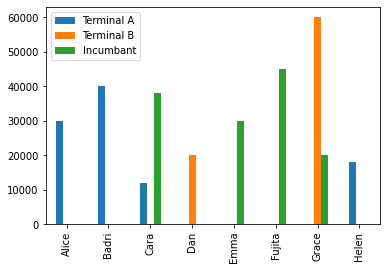

In [14]:
suppliers = pd.DataFrame({src: {"supply": supply[src], 
                              "shipped": m.supply_constraint[src](), 
                              "sensitivity": m.dual[m.supply_constraint[src]]}
                          for src in m.SOURCES}).T

display(suppliers)

customers = pd.DataFrame({dst: {"demand": demand[dst], 
                              "shipped": m.demand_constraint[dst](), 
                              "sensitivity": m.dual[m.demand_constraint[dst]]}
                          for dst in m.DESTINATIONS}).T

display(customers)

shipments = pd.DataFrame({dst: {src: m.x[dst, src]() for src in m.SOURCES} for dst in m.DESTINATIONS}).T
display(shipments)
shipments.plot(kind="bar")


## Graphviz

The `graphviz` utility is a collection of tools for visually graphs and directed graphs. Unfortunately, the package can be troublesome to install on laptops in a way that is compatable with many JupyterLab installations. Accordingly, the following cell is intended for use on Google Colab which provides a preinstalled version of `graphviz`.

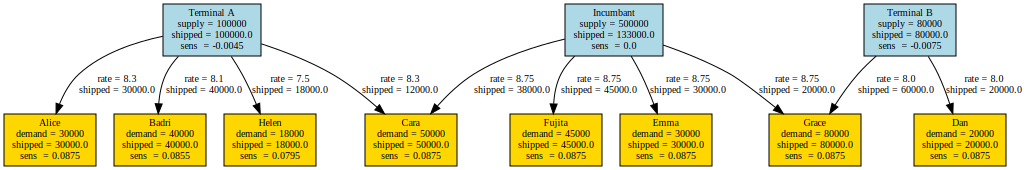

In [15]:
import graphviz
from graphviz import Digraph
import sys

if "google.colab" in sys.modules:

    dot = Digraph(
        node_attr = {"fontsize": "10", "shape": "rectangle", "style": "filled"},
        edge_attr = {"fontsize": "10"}
    )

    for src in m.SOURCES:
        label = f"{src}" \
                + f"\nsupply = {supply[src]}" \
                + f"\nshipped = {m.supply_constraint[src]()}" \
                + f"\nsens  = {m.dual[m.supply_constraint[src]]}"
        dot.node(src, label=label, fillcolor="lightblue")

    for dst in m.DESTINATIONS:
        label = f"{dst}" \
                + f"\ndemand = {demand[dst]}"\
                + f"\nshipped = {m.demand_constraint[dst]()}" \
                + f"\nsens  = {m.dual[m.demand_constraint[dst]]}"
        dot.node(dst, label=label, fillcolor="gold")

    for src in m.SOURCES:
        for dst in m.DESTINATIONS:
            if m.x[dst, src]() > 0:
                dot.edge(src, dst, f"rate = {rates.loc[dst, src]}\nshipped = {m.x[dst, src]()}")

    display(dot)